# THE COVID-19 DATASET ANALYSIS (CM1-4)

### **Group 100**

### *Amy Bhatia* 20876862
### *Mengxuan Shi* 20632148

In [9]:
 import tensorflow as tf
 tf.config.run_functions_eagerly(True)
import keras
from keras.models import Sequential
import pandas as pd
from keras.layers import Dense, SimpleRNN, LSTM
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.callbacks import EarlyStopping

# CM1 Preprocessing

In [10]:
# load dkmacovid training data
df = pd.read_csv('dkmacovid_train.csv')

# remove comma from dataframe in 'Resident Population 2020 Census' and 'Population Density 2020 Census'
df = df.replace(',','', regex=True)
# convert string to numeric data
df['Resident Population 2020 Census'] = df['Resident Population 2020 Census'].astype(float) 
df['Population Density 2020 Census'] = df['Population Density 2020 Census'].astype(float) 
df['Confirmed'].replace({True:1,False:0},inplace=True)
df['Deaths'].replace({True:1,False:0},inplace=True)
df['Recovered'].replace({True:1,False:0},inplace=True)

from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
# select features to normalize
features=['Day','State ID','Lat','Long_','Active', 'Incident_Rate', 'Total_Test_Results', 'Case_Fatality_Ratio', 'Testing_Rate', 'Resident Population 2020 Census', 'Population Density 2020 Census', 'Density Rank 2020 Census', 'SexRatio']
df_z= df.loc[:,features]
df_z.iloc[:,:]=std_scaler.fit_transform(df_z.iloc[:,:])
df_z.head()

X= df_z.loc[:,features]
# set y1= Confirmed y2= deaths y3= Recovered
y1=df.loc[:,'Confirmed']
y2=df.loc[:,'Deaths']
y3=df.loc[:,'Recovered']

In [11]:
df.isnull().sum()

Day                                0
State ID                           0
State                              0
Lat                                0
Long_                              0
Active                             0
Incident_Rate                      0
Total_Test_Results                 0
Case_Fatality_Ratio                0
Testing_Rate                       0
Resident Population 2020 Census    0
Population Density 2020 Census     0
Density Rank 2020 Census           0
SexRatio                           0
Confirmed                          0
Deaths                             0
Recovered                          0
dtype: int64

The dataset was checked for null values as the presence of these can hamper the performance of neural networks which are trained on the data for further analysis. 

Some other pre-processing steps were performed to convert the data into a neural network ready format. This included removing 'commas' from some columns and updating the data types for columns which contained numbers in string formats. Finally, the dataset columns were scaled using StandardScaler. This is an important stpe to enhance the training and performance of neural networks.

\pagebreak

Defining below some functions to be used for training further models

In [12]:
#Defining a function which will be used for plotting model performance graphs
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [13]:
def model_trainer_1(model, y, X, epo, batch, es):
  model.reset_metrics()
  model.reset_states()
  y=np.ravel(y)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state =0)
  features = X_train.shape[1]
  strat_time = time.time()
 
  # ADD early stopping [1]
  if (es=='0'):
    history = model.fit(X_train,y_train,epochs=epo,validation_split=0.25, batch_size=batch)
  else:
    history = model.fit(X_train,y_train,epochs=epo,validation_split=0.25, batch_size=batch, callbacks=[es])

  end_time = time.time()
  print("Running time is {:.2f} seconds per {} epoches".format(end_time-strat_time, epo))
  loss, acc = model.evaluate(X_test, y_test, verbose=0)
  print('Test Accuracy: %.3f' % acc)

  return history

# CM2

Below is a neural network which has 2 hidden layers with 20 units each. The activation function used in both the layers is ReLU activation. For the output layer, softmax activation function has been used. Three separate models have been trained for the labels 'Confirmed', 'Recovered' and 'Deaths'.

In [14]:
model_cm2 = Sequential()
model_cm2.add(Dense(20, activation='relu', input_shape=(13,)))
model_cm2.add(Dense(20, activation='relu'))
model_cm2.add(Dense(1, activation='softmax'))
model_cm2.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
                  

In [15]:
es_cm2= EarlyStopping(
    monitor='val_loss', 
    patience=8, 
    min_delta=0.001, 
  
)

In [16]:
history_cm2_y1=model_trainer_1(model_cm2, y1, X, 200, 10,es_cm2)

Epoch 1/200
 3/83 [>.............................] - ETA: 2s - loss: 0.4435 - accuracy: 0.9389

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


81/83 [============================>.] - ETA: 0s - loss: 0.4513 - accuracy: 0.9603

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


83/83 [==============================] - 2s 29ms/step - loss: 0.4494 - accuracy: 0.9603 - val_loss: 0.3042 - val_accuracy: 0.9710
Epoch 2/200
83/83 [==============================] - 2s 30ms/step - loss: 0.3027 - accuracy: 0.9442 - val_loss: 0.2153 - val_accuracy: 0.9710
Epoch 3/200
83/83 [==============================] - 2s 28ms/step - loss: 0.2551 - accuracy: 0.9448 - val_loss: 0.1764 - val_accuracy: 0.9710
Epoch 4/200
83/83 [==============================] - 2s 27ms/step - loss: 0.2307 - accuracy: 0.9484 - val_loss: 0.1590 - val_accuracy: 0.9710
Epoch 5/200
83/83 [==============================] - 2s 29ms/step - loss: 0.1669 - accuracy: 0.9664 - val_loss: 0.1500 - val_accuracy: 0.9710
Epoch 6/200
83/83 [==============================] - 2s 29ms/step - loss: 0.1814 - accuracy: 0.9547 - val_loss: 0.1440 - val_accuracy: 0.9710
Epoch 7/200
83/83 [==============================] - 2s 27ms/step - loss: 0.1684 - accuracy: 0.9605 - val_loss: 0.1401 - val_accuracy: 0.9710
Epoch 8/200
83/83 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


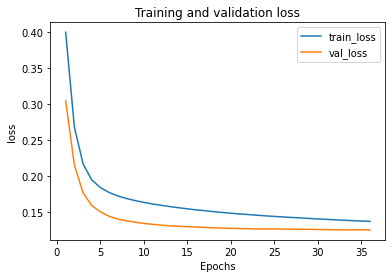

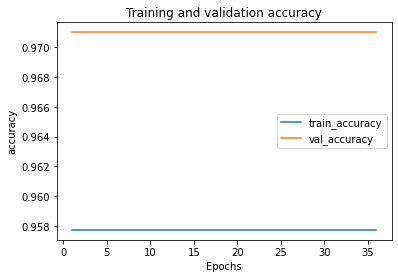

In [17]:
plot_metric(history_cm2_y1,'loss')
plot_metric(history_cm2_y1,'accuracy')

In [18]:
history_cm2_y2=model_trainer_1(model_cm2, y2, X, 200, 10,es_cm2)

Epoch 1/200
 4/83 [>.............................] - ETA: 1s - loss: 0.1035 - accuracy: 0.9750

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


82/83 [============================>.] - ETA: 0s - loss: 0.3786 - accuracy: 0.9000

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


83/83 [==============================] - 2s 27ms/step - loss: 0.3758 - accuracy: 0.9010 - val_loss: 0.3686 - val_accuracy: 0.8986
Epoch 2/200
83/83 [==============================] - 2s 29ms/step - loss: 0.3177 - accuracy: 0.9010 - val_loss: 0.3325 - val_accuracy: 0.8986
Epoch 3/200
83/83 [==============================] - 2s 26ms/step - loss: 0.3008 - accuracy: 0.9010 - val_loss: 0.3175 - val_accuracy: 0.8986
Epoch 4/200
83/83 [==============================] - 2s 26ms/step - loss: 0.2922 - accuracy: 0.9010 - val_loss: 0.3084 - val_accuracy: 0.8986
Epoch 5/200
83/83 [==============================] - 2s 27ms/step - loss: 0.2858 - accuracy: 0.9010 - val_loss: 0.3007 - val_accuracy: 0.8986
Epoch 6/200
83/83 [==============================] - 2s 26ms/step - loss: 0.2804 - accuracy: 0.9010 - val_loss: 0.2944 - val_accuracy: 0.8986
Epoch 7/200
83/83 [==============================] - 2s 26ms/step - loss: 0.2759 - accuracy: 0.9010 - val_loss: 0.2890 - val_accuracy: 0.8986
Epoch 8/200
83/83 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


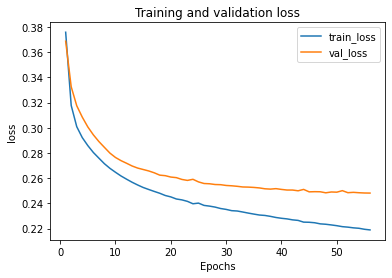

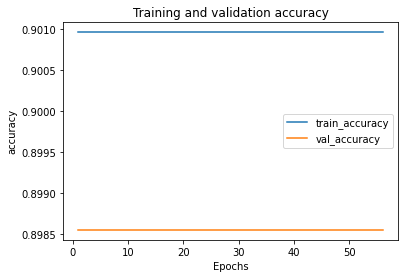

In [19]:
plot_metric(history_cm2_y2,'loss')
plot_metric(history_cm2_y2,'accuracy')

In [20]:
history_cm2_y3=model_trainer_1(model_cm2, y3, X, 200, 10,es_cm2)

Epoch 1/200
 4/83 [>.............................] - ETA: 1s - loss: 1.7716 - accuracy: 0.5750

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


81/83 [============================>.] - ETA: 0s - loss: 0.9266 - accuracy: 0.6222

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


83/83 [==============================] - 3s 31ms/step - loss: 0.9180 - accuracy: 0.6232 - val_loss: 0.6771 - val_accuracy: 0.6196
Epoch 2/200
83/83 [==============================] - 2s 27ms/step - loss: 0.6151 - accuracy: 0.6232 - val_loss: 0.5639 - val_accuracy: 0.6196
Epoch 3/200
83/83 [==============================] - 2s 27ms/step - loss: 0.5332 - accuracy: 0.6232 - val_loss: 0.5077 - val_accuracy: 0.6196
Epoch 4/200
83/83 [==============================] - 2s 27ms/step - loss: 0.4853 - accuracy: 0.6232 - val_loss: 0.4726 - val_accuracy: 0.6196
Epoch 5/200
83/83 [==============================] - 2s 28ms/step - loss: 0.4532 - accuracy: 0.6232 - val_loss: 0.4473 - val_accuracy: 0.6196
Epoch 6/200
83/83 [==============================] - 2s 27ms/step - loss: 0.4290 - accuracy: 0.6232 - val_loss: 0.4269 - val_accuracy: 0.6196
Epoch 7/200
83/83 [==============================] - 2s 27ms/step - loss: 0.4093 - accuracy: 0.6232 - val_loss: 0.4109 - val_accuracy: 0.6196
Epoch 8/200
83/83 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


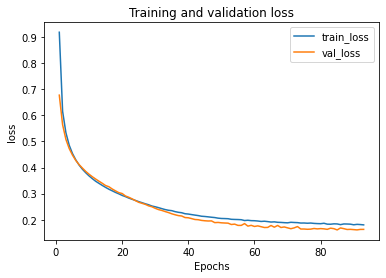

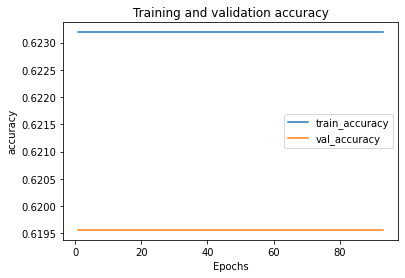

In [21]:
plot_metric(history_cm2_y3,'loss')
plot_metric(history_cm2_y3,'accuracy')

\pagebreak

# CM3

For this question, we have tried using different models to find out the one that performs the best. The models that we have considered and compared  include a basic DNN architecture, 2 LSTM models and a RNN model. 

### CM3 - (i) [2]

Below is a neural network which has **7 hidden layers** with **64** and **128** units varying in each as can been seen from the code. The activation function used in all the hidden layers is **LeakyReLU activation** since it offers an improvement above the ReLU function. For the output layer, **sigmoid activation function** has been used. The optimizer which we have used is '**sgd**' which stands for Stochastic Gradient Descent. To prevent overfitting, the regularization method which we have used here is **early stopping** with a **delta value of 0.001**. The model stops training after we see no improvement in the validation loss for 4 epochs. The input layer uses 13 features to determine the output class label. Three separate models have been trained (**200 epochs and 40 batch size**) for the labels 'Confirmed', 'Recovered' and 'Deaths'. The performance of all the three models has been plotted using two graphs - 
<br> The training and validation loss by epochs
<br> The training and validation accuracy by epochs

In [22]:
# Basic architecture of a NNet
model_dnn = Sequential()
model_dnn.add(Dense(64, activation='LeakyReLU', input_shape=(13,)))
model_dnn.add(Dense(128, activation='LeakyReLU'))
model_dnn.add(Dense(128, activation='LeakyReLU'))
model_dnn.add(Dense(128, activation='LeakyReLU'))
model_dnn.add(Dense(64, activation='LeakyReLU'))
model_dnn.add(Dense(64, activation='LeakyReLU'))
model_dnn.add(Dense(64, activation='LeakyReLU'))
model_dnn.add(Dense(1, activation='sigmoid'))
model_dnn.compile(loss='binary_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
                  

In [23]:
es_dnn= EarlyStopping(
    monitor='val_loss', 
    patience=4, 
    min_delta=0.001, 
  
)

In [24]:
history_dnn_y1=model_trainer_1(model_dnn, y1, X, 200, 40,es_dnn)

Epoch 1/200
 3/21 [===>..........................] - ETA: 0s - loss: 0.7063 - accuracy: 0.4167

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


21/21 [==============================] - 1s 40ms/step - loss: 0.6741 - accuracy: 0.7101 - val_loss: 0.5801 - val_accuracy: 0.9710
Epoch 2/200
 1/21 [>.............................] - ETA: 0s - loss: 0.5854 - accuracy: 0.9500

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


21/21 [==============================] - 1s 37ms/step - loss: 0.5611 - accuracy: 0.9499 - val_loss: 0.4745 - val_accuracy: 0.9710
Epoch 3/200
21/21 [==============================] - 1s 37ms/step - loss: 0.4646 - accuracy: 0.9547 - val_loss: 0.3825 - val_accuracy: 0.9710
Epoch 4/200
21/21 [==============================] - 1s 37ms/step - loss: 0.3804 - accuracy: 0.9565 - val_loss: 0.3039 - val_accuracy: 0.9710
Epoch 5/200
21/21 [==============================] - 1s 38ms/step - loss: 0.3082 - accuracy: 0.9585 - val_loss: 0.2421 - val_accuracy: 0.9710
Epoch 6/200
21/21 [==============================] - 1s 36ms/step - loss: 0.2507 - accuracy: 0.9615 - val_loss: 0.1991 - val_accuracy: 0.9710
Epoch 7/200
21/21 [==============================] - 1s 36ms/step - loss: 0.2337 - accuracy: 0.9516 - val_loss: 0.1712 - val_accuracy: 0.9710
Epoch 8/200
21/21 [==============================] - 1s 38ms/step - loss: 0.2107 - accuracy: 0.9537 - val_loss: 0.1544 - val_accuracy: 0.9710
Epoch 9/200
21/21 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


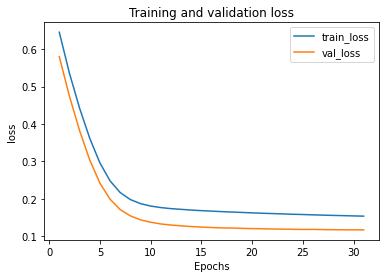

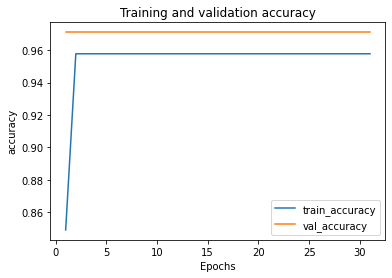

In [25]:
plot_metric(history_dnn_y1,'loss')
plot_metric(history_dnn_y1,'accuracy')

In [26]:
history_dnn_y2=model_trainer_1(model_dnn, y2, X, 200, 40,es_dnn)

Epoch 1/200
 3/21 [===>..........................] - ETA: 0s - loss: 0.3961 - accuracy: 0.8917

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


21/21 [==============================] - 1s 39ms/step - loss: 0.3744 - accuracy: 0.9010 - val_loss: 0.3728 - val_accuracy: 0.8986
Epoch 2/200
 1/21 [>.............................] - ETA: 0s - loss: 0.3727 - accuracy: 0.8750

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


21/21 [==============================] - 1s 35ms/step - loss: 0.3393 - accuracy: 0.9010 - val_loss: 0.3467 - val_accuracy: 0.8986
Epoch 3/200
21/21 [==============================] - 1s 36ms/step - loss: 0.3237 - accuracy: 0.9010 - val_loss: 0.3324 - val_accuracy: 0.8986
Epoch 4/200
21/21 [==============================] - 1s 36ms/step - loss: 0.3147 - accuracy: 0.9010 - val_loss: 0.3235 - val_accuracy: 0.8986
Epoch 5/200
21/21 [==============================] - 1s 35ms/step - loss: 0.3089 - accuracy: 0.9010 - val_loss: 0.3171 - val_accuracy: 0.8986
Epoch 6/200
21/21 [==============================] - 1s 35ms/step - loss: 0.3044 - accuracy: 0.9010 - val_loss: 0.3115 - val_accuracy: 0.8986
Epoch 7/200
21/21 [==============================] - 1s 36ms/step - loss: 0.3007 - accuracy: 0.9010 - val_loss: 0.3069 - val_accuracy: 0.8986
Epoch 8/200
21/21 [==============================] - 1s 36ms/step - loss: 0.2970 - accuracy: 0.9010 - val_loss: 0.3030 - val_accuracy: 0.8986
Epoch 9/200
21/21 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


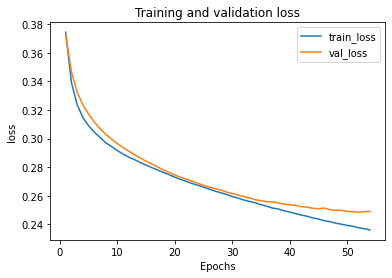

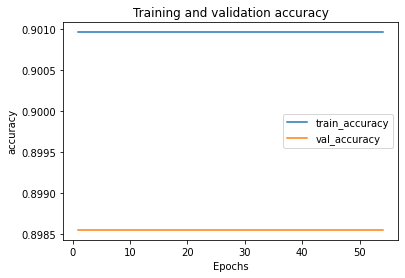

In [27]:
plot_metric(history_dnn_y2,'loss')
plot_metric(history_dnn_y2,'accuracy')

In [28]:
history_dnn_y3=model_trainer_1(model_dnn, y3, X, 200, 40,es_dnn)

Epoch 1/200
 3/21 [===>..........................] - ETA: 0s - loss: 1.5531 - accuracy: 0.5833

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


21/21 [==============================] - 1s 40ms/step - loss: 0.9241 - accuracy: 0.6280 - val_loss: 0.6806 - val_accuracy: 0.6594
Epoch 2/200
 1/21 [>.............................] - ETA: 0s - loss: 0.5940 - accuracy: 0.7000

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


21/21 [==============================] - 1s 38ms/step - loss: 0.6384 - accuracy: 0.6655 - val_loss: 0.6153 - val_accuracy: 0.7065
Epoch 3/200
21/21 [==============================] - 1s 37ms/step - loss: 0.5922 - accuracy: 0.6848 - val_loss: 0.5832 - val_accuracy: 0.7029
Epoch 4/200
21/21 [==============================] - 1s 37ms/step - loss: 0.5609 - accuracy: 0.7017 - val_loss: 0.5559 - val_accuracy: 0.6993
Epoch 5/200
21/21 [==============================] - 1s 35ms/step - loss: 0.5333 - accuracy: 0.7246 - val_loss: 0.5316 - val_accuracy: 0.7065
Epoch 6/200
21/21 [==============================] - 1s 37ms/step - loss: 0.5091 - accuracy: 0.7464 - val_loss: 0.5094 - val_accuracy: 0.7210
Epoch 7/200
21/21 [==============================] - 1s 36ms/step - loss: 0.4861 - accuracy: 0.7585 - val_loss: 0.4895 - val_accuracy: 0.7319
Epoch 8/200
21/21 [==============================] - 1s 38ms/step - loss: 0.4661 - accuracy: 0.7766 - val_loss: 0.4706 - val_accuracy: 0.7391
Epoch 9/200
21/21 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


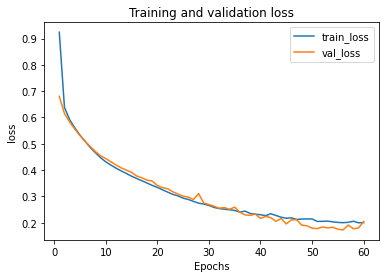

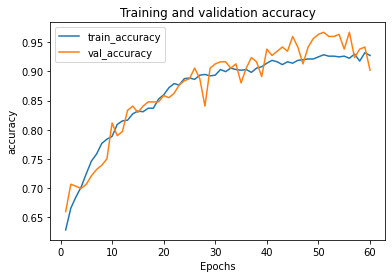

In [29]:
plot_metric(history_dnn_y3,'loss')
plot_metric(history_dnn_y3,'accuracy')

### LSTM [3]

In [30]:
# LSTM

import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split 

In [31]:
def model_trainer2(model, y, X, epo,batch, es ):
  model.reset_metrics()
  model.reset_states()
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state =0)
  features = X_train.shape[1]
  X_train = X_train.values.reshape(X_train.shape[0], features,1)
  X_test  = X_test.values.reshape(X_test.shape[0], features,1)
  strat_time = time.time()
  
  # ADD early stopping
  if (es=='0'):
    history = model.fit(X_train,y_train,epochs=epo,validation_split=0.25, batch_size=batch)
  else:
    history = model.fit(X_train,y_train,epochs=epo,validation_split=0.25, batch_size=batch, callbacks=[es])

  end_time = time.time()
  print("Running time is {:.2f} seconds per {} epoches".format(end_time-strat_time, epo))
  loss, acc = model.evaluate(X_test, y_test, verbose=0)
  print('Test Accuracy: %.3f' % acc)
  return history

### CM3- (ii)


Below is a neural network which which uses the LSTM architecture followed by  **3 hidden layers** with **40** and **10** units varying in each as can been seen from the code. The activation functions used include **ReLU** and **softmax** activations. For the output layer, **sigmoid activation function** has been used. The optimizer which we have used is '**Adam**' which performs faster than sgd. To prevent overfitting, we tried using **early stopping** with a **delta value of 0.001**, but it worsened the performance and hence we have set the corresponding parameter to **zero**. The input layer uses 13 features to determine the output class label. Three separate models have been trained (**200 epochs and 40 batch size**) for the labels 'Confirmed', 'Recovered' and 'Deaths'. The performance of all the three models has been plotted using two graphs - 
<br> The training and validation loss by epochs
<br> The training and validation accuracy by epochs

In [32]:
# 0.16491 score model
model_LSTM = Sequential()
model_LSTM.add(LSTM(40, input_shape=(13,1)))  #, return_sequences=True 
model_LSTM.add(Dense(40, activation='relu'))
model_LSTM.add(Dense(40, activation='relu'))
model_LSTM.add(Dense(10, activation='softmax'))
model_LSTM.add(Dense(1, activation='sigmoid'))
model_LSTM.compile(loss='mse',
              optimizer='adam',
              metrics=['accuracy'])
model_LSTM.summary()
model_LSTM

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40)                6720      
_________________________________________________________________
dense_15 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_16 (Dense)             (None, 40)                1640      
_________________________________________________________________
dense_17 (Dense)             (None, 10)                410       
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 11        
Total params: 10,421
Trainable params: 10,421
Non-trainable params: 0
_________________________________________________________________


In [33]:
hist_lstm_y1=model_trainer2(model_LSTM, y1, X, 100, 10, '0')

Epoch 1/100
 2/83 [..............................] - ETA: 4s - loss: 0.2564 - accuracy: 0.0500    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


83/83 [==============================] - 5s 59ms/step - loss: 0.2245 - accuracy: 0.6615 - val_loss: 0.1393 - val_accuracy: 0.9710
Epoch 2/100
83/83 [==============================] - 5s 65ms/step - loss: 0.1303 - accuracy: 0.9635 - val_loss: 0.0926 - val_accuracy: 0.9710
Epoch 3/100
83/83 [==============================] - 5s 57ms/step - loss: 0.0948 - accuracy: 0.9569 - val_loss: 0.0777 - val_accuracy: 0.9710
Epoch 4/100
83/83 [==============================] - 5s 58ms/step - loss: 0.0807 - accuracy: 0.9600 - val_loss: 0.0678 - val_accuracy: 0.9710
Epoch 5/100
83/83 [==============================] - 5s 57ms/step - loss: 0.0691 - accuracy: 0.9651 - val_loss: 0.0604 - val_accuracy: 0.9710
Epoch 6/100
83/83 [==============================] - 5s 58ms/step - loss: 0.0648 - accuracy: 0.9612 - val_loss: 0.0549 - val_accuracy: 0.9710
Epoch 7/100
83/83 [==============================] - 5s 65ms/step - loss: 0.0646 - accuracy: 0.9535 - val_loss: 0.0505 - val_accuracy: 0.9710
Epoch 8/100
83/83 

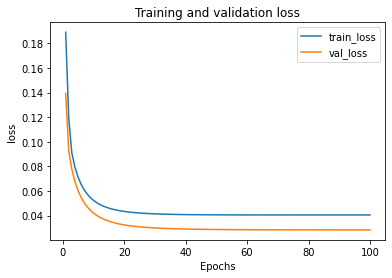

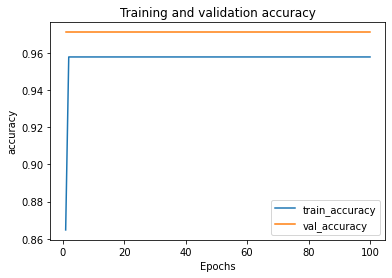

In [34]:
plot_metric(hist_lstm_y1,'loss')
plot_metric(hist_lstm_y1,'accuracy')

In [35]:
hist_lstm_y2=model_trainer2(model_LSTM, y2, X, 100, 10, '0')

Epoch 1/100
 2/83 [..............................] - ETA: 4s - loss: 0.0476 - accuracy: 0.9500

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


83/83 [==============================] - 5s 65ms/step - loss: 0.0922 - accuracy: 0.9010 - val_loss: 0.0941 - val_accuracy: 0.8986
Epoch 2/100
83/83 [==============================] - 5s 64ms/step - loss: 0.0916 - accuracy: 0.9010 - val_loss: 0.0934 - val_accuracy: 0.8986
Epoch 3/100
83/83 [==============================] - 5s 65ms/step - loss: 0.0911 - accuracy: 0.9010 - val_loss: 0.0929 - val_accuracy: 0.8986
Epoch 4/100
83/83 [==============================] - 5s 64ms/step - loss: 0.0906 - accuracy: 0.9010 - val_loss: 0.0925 - val_accuracy: 0.8986
Epoch 5/100
83/83 [==============================] - 5s 57ms/step - loss: 0.0902 - accuracy: 0.9010 - val_loss: 0.0921 - val_accuracy: 0.8986
Epoch 6/100
83/83 [==============================] - 5s 59ms/step - loss: 0.0899 - accuracy: 0.9010 - val_loss: 0.0918 - val_accuracy: 0.8986
Epoch 7/100
83/83 [==============================] - 5s 59ms/step - loss: 0.0897 - accuracy: 0.9010 - val_loss: 0.0916 - val_accuracy: 0.8986
Epoch 8/100
83/83 

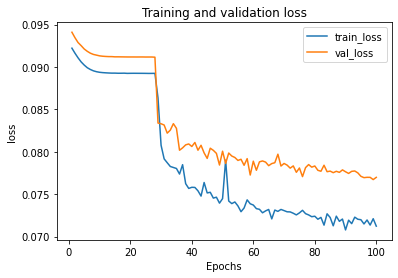

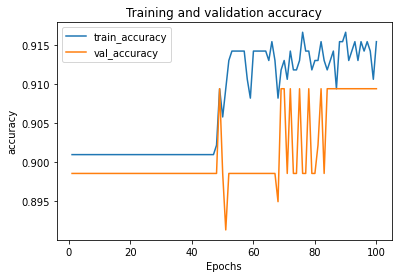

In [36]:
plot_metric(hist_lstm_y2,'loss')
plot_metric(hist_lstm_y2,'accuracy')

In [37]:
hist_lstm_y3=model_trainer2(model_LSTM, y3, X, 100, 10, '0')

Epoch 1/100
 3/83 [>.............................] - ETA: 3s - loss: 0.4320 - accuracy: 0.4667

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


83/83 [==============================] - 5s 58ms/step - loss: 0.3184 - accuracy: 0.6147 - val_loss: 0.2864 - val_accuracy: 0.6703
Epoch 2/100
83/83 [==============================] - 5s 57ms/step - loss: 0.2645 - accuracy: 0.6473 - val_loss: 0.2160 - val_accuracy: 0.6812
Epoch 3/100
83/83 [==============================] - 5s 63ms/step - loss: 0.2184 - accuracy: 0.6522 - val_loss: 0.2005 - val_accuracy: 0.6848
Epoch 4/100
83/83 [==============================] - 5s 55ms/step - loss: 0.2098 - accuracy: 0.6558 - val_loss: 0.1913 - val_accuracy: 0.6848
Epoch 5/100
83/83 [==============================] - 5s 64ms/step - loss: 0.1938 - accuracy: 0.6558 - val_loss: 0.1755 - val_accuracy: 0.6848
Epoch 6/100
83/83 [==============================] - 5s 63ms/step - loss: 0.1784 - accuracy: 0.6558 - val_loss: 0.1640 - val_accuracy: 0.6848
Epoch 7/100
83/83 [==============================] - 5s 63ms/step - loss: 0.1697 - accuracy: 0.6606 - val_loss: 0.1593 - val_accuracy: 0.6957
Epoch 8/100
83/83 

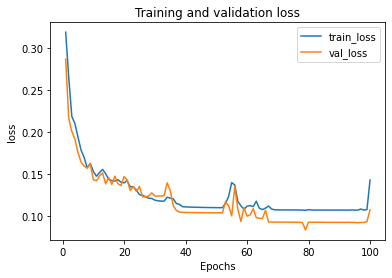

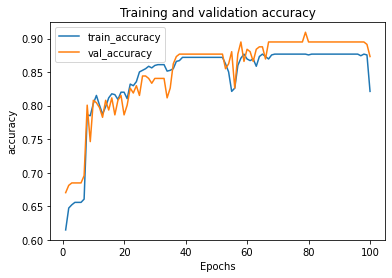

In [38]:
plot_metric(hist_lstm_y3,'loss')
plot_metric(hist_lstm_y3,'accuracy')

### CM3- (iii)

Below is a neural network which has been trained based upon the LSTM architecture exactly similar to the previous one. The only difference is that we have used the **'sgd'** optimizer here to see the changes in the performance.

In [39]:
# LSTM with sgd
model_LSTM.compile(loss='mse',
              optimizer='sgd',
              metrics=['accuracy'])

In [40]:
hist_lstm_y1_sgd=model_trainer2(model_LSTM, y1, X,  100, 10, '0')

Epoch 1/100
 2/83 [..............................] - ETA: 4s - loss: 0.2143 - accuracy: 0.7000

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


83/83 [==============================] - 5s 56ms/step - loss: 0.2781 - accuracy: 0.6137 - val_loss: 0.2791 - val_accuracy: 0.6087
Epoch 2/100
83/83 [==============================] - 4s 53ms/step - loss: 0.2488 - accuracy: 0.6449 - val_loss: 0.2642 - val_accuracy: 0.6159
Epoch 3/100
83/83 [==============================] - 4s 54ms/step - loss: 0.2205 - accuracy: 0.6691 - val_loss: 0.2161 - val_accuracy: 0.6594
Epoch 4/100
83/83 [==============================] - 4s 53ms/step - loss: 0.1827 - accuracy: 0.7058 - val_loss: 0.2036 - val_accuracy: 0.6630
Epoch 5/100
83/83 [==============================] - 4s 54ms/step - loss: 0.1756 - accuracy: 0.7025 - val_loss: 0.1919 - val_accuracy: 0.6630
Epoch 6/100
83/83 [==============================] - 4s 53ms/step - loss: 0.1723 - accuracy: 0.6899 - val_loss: 0.1800 - val_accuracy: 0.6630
Epoch 7/100
83/83 [==============================] - 4s 54ms/step - loss: 0.1653 - accuracy: 0.6919 - val_loss: 0.1681 - val_accuracy: 0.6630
Epoch 8/100
83/83 

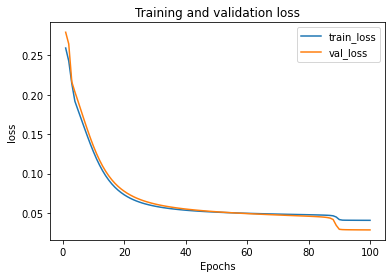

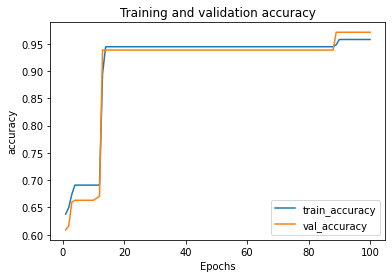

In [41]:
plot_metric(hist_lstm_y1_sgd,'loss')
plot_metric(hist_lstm_y1_sgd,'accuracy')

In [42]:
hist_lstm_y2_sgd=model_trainer2(model_LSTM, y2, X, 100, 10, '0')

Epoch 1/100
 3/83 [>.............................] - ETA: 3s - loss: 0.0307 - accuracy: 0.9667

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


83/83 [==============================] - 5s 58ms/step - loss: 0.0954 - accuracy: 0.9010 - val_loss: 0.0975 - val_accuracy: 0.8986
Epoch 2/100
83/83 [==============================] - 5s 63ms/step - loss: 0.0950 - accuracy: 0.9010 - val_loss: 0.0958 - val_accuracy: 0.8986
Epoch 3/100
83/83 [==============================] - 5s 58ms/step - loss: 0.0939 - accuracy: 0.9010 - val_loss: 0.0946 - val_accuracy: 0.8986
Epoch 4/100
83/83 [==============================] - 5s 56ms/step - loss: 0.0933 - accuracy: 0.8998 - val_loss: 0.0952 - val_accuracy: 0.8986
Epoch 5/100
83/83 [==============================] - 5s 55ms/step - loss: 0.0931 - accuracy: 0.9010 - val_loss: 0.0951 - val_accuracy: 0.8986
Epoch 6/100
83/83 [==============================] - 5s 56ms/step - loss: 0.0932 - accuracy: 0.9010 - val_loss: 0.0955 - val_accuracy: 0.9094
Epoch 7/100
83/83 [==============================] - 5s 56ms/step - loss: 0.0931 - accuracy: 0.8986 - val_loss: 0.0951 - val_accuracy: 0.9058
Epoch 8/100
83/83 

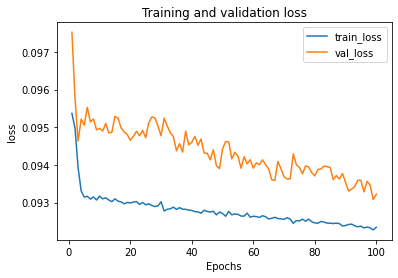

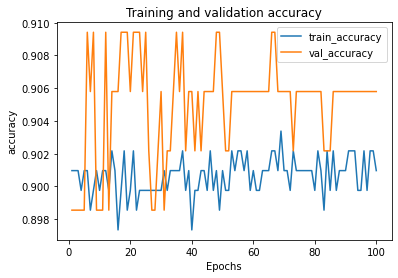

In [43]:
plot_metric(hist_lstm_y2_sgd,'loss')
plot_metric(hist_lstm_y2_sgd,'accuracy')

In [44]:
hist_lstm_y3_sgd=model_trainer2(model_LSTM, y3, X, 100, 10, '0')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/100
83/83 [==============================] - 5s 58ms/step - loss: 0.3138 - accuracy: 0.6329 - val_loss: 0.2984 - val_accuracy: 0.6522
Epoch 2/100
83/83 [==============================] - 5s 58ms/step - loss: 0.3088 - accuracy: 0.6365 - val_loss: 0.2933 - val_accuracy: 0.6522
Epoch 3/100
83/83 [==============================] - 5s 56ms/step - loss: 0.2999 - accuracy: 0.6365 - val_loss: 0.2601 - val_accuracy: 0.6848
Epoch 4/100
83/83 [==============================] - 5s 57ms/step - loss: 0.2827 - accuracy: 0.6558 - val_loss: 0.2552 - val_accuracy: 0.6848
Epoch 5/100
83/83 [==============================] - 5s 56ms/step - loss: 0.2778 - accuracy: 0.6558 - val_loss: 0.2499 - val_accuracy: 0.6848
Epoch 6/100
83/83 [==============================] - 5s 62ms/step - loss: 0.2719 - accuracy: 0.6558 - val_loss: 0.2440 - val_accuracy: 0.6848
Epoch 7/100
83/83 [==============================] - 5s 63ms/step - loss: 0.2653 - accuracy: 0.6558 - val_loss: 0.2376 - val_accuracy: 0.6848
Epoch 

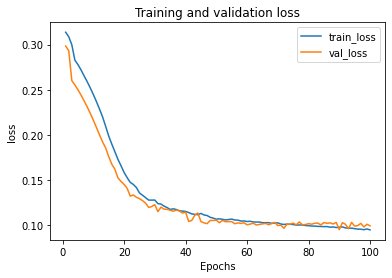

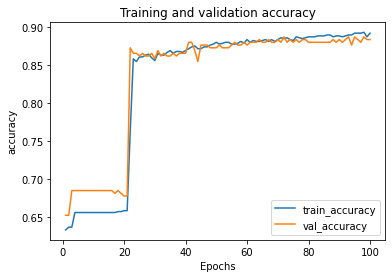

In [45]:
plot_metric(hist_lstm_y3_sgd,'loss')
plot_metric(hist_lstm_y3_sgd,'accuracy')

From the above trainings and plots, we can observe-

LSTM with Adam optimizer gives higher accuracy and much shorter computing time than LSTM model with sgd optimizer.

Train losses roughly remained constant with sgd optimizer, likely due to gradient descent with decaying learning rate for the error calculation. [4]


### CM3- (iv)

Below is a neural network which which uses a **Simple RNN** architecture followed by  **3 hidden layers** with **64**, **32** and **16** units respectively. The activation function used here is **ReLU activation**. For the output layer, **softmax activation function** has been used. The optimizer which we have used is '**Adam**' with a **learning rate of 0.001** and this performs faster than sgd. To prevent overfitting, the regularization method which we have used here is **early stopping** with a **delta value of 0.001**. The model stops training after we see no improvement in the validation loss for 8 epochs. The input layer uses 13 features to determine the output class label. Three separate models have been trained (**100 epochs and 10 batch size**) for the labels 'Confirmed', 'Recovered' and 'Deaths'. The performance of all the three models has been plotted using two graphs - 
<br> The training and validation loss by epochs
<br> The training and validation accuracy by epochs

In [46]:

model_RNN = Sequential() 
model_RNN.add(SimpleRNN(128,input_shape=(13,1),activation='relu')) 
model_RNN.add(Dense(64,activation='relu')) 
model_RNN.add(Dense(32,activation='relu')) 
model_RNN.add(Dense(16,activation='relu')) 
model_RNN.add(Dense(3,activation='softmax'))
model_RNN.compile(loss='sparse_categorical_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=0.001) ,metrics=['accuracy'])


In [47]:

es_rnn= EarlyStopping(
    monitor='val_loss', 
    patience=8, 
    min_delta=0.001, 
  
)

In [48]:
hist_rnn_y1=model_trainer2(model_RNN, y1, X,100 , 10, es_rnn)

Epoch 1/100
 1/83 [..............................] - ETA: 5s - loss: 1.0992 - accuracy: 0.1000

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


83/83 [==============================] - 5s 60ms/step - loss: 0.5425 - accuracy: 0.8292 - val_loss: 0.1371 - val_accuracy: 0.9710
Epoch 2/100
83/83 [==============================] - 4s 53ms/step - loss: 0.1488 - accuracy: 0.9658 - val_loss: 0.1416 - val_accuracy: 0.9710
Epoch 3/100
83/83 [==============================] - 5s 59ms/step - loss: 0.1536 - accuracy: 0.9605 - val_loss: 0.1301 - val_accuracy: 0.9710
Epoch 4/100
83/83 [==============================] - 4s 54ms/step - loss: 0.1449 - accuracy: 0.9617 - val_loss: 0.1284 - val_accuracy: 0.9710
Epoch 5/100
83/83 [==============================] - 5s 59ms/step - loss: 0.1502 - accuracy: 0.9619 - val_loss: 0.1167 - val_accuracy: 0.9710
Epoch 6/100
83/83 [==============================] - 4s 52ms/step - loss: 0.1175 - accuracy: 0.9638 - val_loss: 0.1210 - val_accuracy: 0.9710
Epoch 7/100
83/83 [==============================] - 4s 52ms/step - loss: 0.1277 - accuracy: 0.9584 - val_loss: 0.1228 - val_accuracy: 0.9710
Epoch 8/100
83/83 

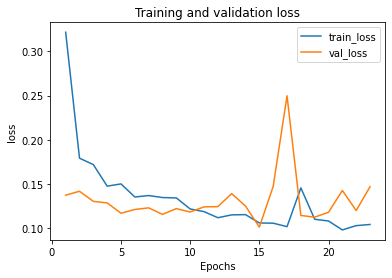

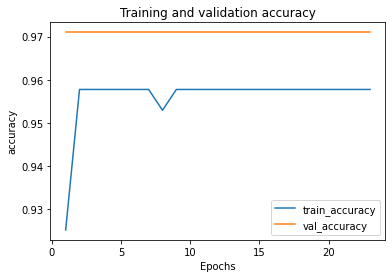

In [49]:
plot_metric(hist_rnn_y1,'loss')
plot_metric(hist_rnn_y1,'accuracy')

In [50]:
hist_rnn_y2=model_trainer2(model_RNN, y2, X,100 , 10, es_rnn)

Epoch 1/100
 1/83 [..............................] - ETA: 3s - loss: 0.6408 - accuracy: 0.9000

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


83/83 [==============================] - 5s 55ms/step - loss: 0.2901 - accuracy: 0.9010 - val_loss: 0.2794 - val_accuracy: 0.8986
Epoch 2/100
83/83 [==============================] - 5s 60ms/step - loss: 0.2382 - accuracy: 0.9010 - val_loss: 0.3150 - val_accuracy: 0.8986
Epoch 3/100
83/83 [==============================] - 5s 56ms/step - loss: 0.2330 - accuracy: 0.9010 - val_loss: 0.3065 - val_accuracy: 0.8986
Epoch 4/100
83/83 [==============================] - 5s 56ms/step - loss: 0.2154 - accuracy: 0.8973 - val_loss: 0.3159 - val_accuracy: 0.8986
Epoch 5/100
83/83 [==============================] - 5s 55ms/step - loss: 0.2161 - accuracy: 0.9070 - val_loss: 0.3697 - val_accuracy: 0.8768
Epoch 6/100
83/83 [==============================] - 4s 54ms/step - loss: 0.2580 - accuracy: 0.9010 - val_loss: 0.3001 - val_accuracy: 0.8949
Epoch 7/100
83/83 [==============================] - 4s 54ms/step - loss: 0.2076 - accuracy: 0.9082 - val_loss: 0.2935 - val_accuracy: 0.9058
Epoch 8/100
83/83 

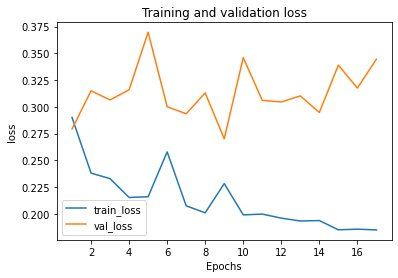

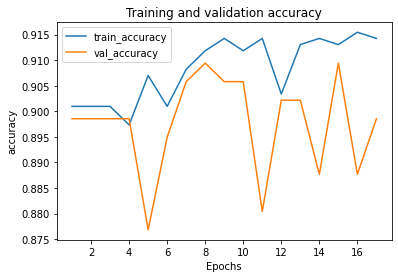

In [51]:
plot_metric(hist_rnn_y2,'loss')
plot_metric(hist_rnn_y2,'accuracy')

In [52]:
hist_rnn_y3=model_trainer2(model_RNN, y3, X,100 , 10, es_rnn)

Epoch 1/100
 2/83 [..............................] - ETA: 4s - loss: 2.7343 - accuracy: 0.5500

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


83/83 [==============================] - 5s 55ms/step - loss: 0.6760 - accuracy: 0.6618 - val_loss: 0.4367 - val_accuracy: 0.8043
Epoch 2/100
83/83 [==============================] - 5s 60ms/step - loss: 0.3592 - accuracy: 0.8478 - val_loss: 0.2881 - val_accuracy: 0.8913
Epoch 3/100
83/83 [==============================] - 4s 53ms/step - loss: 0.2542 - accuracy: 0.9070 - val_loss: 0.2044 - val_accuracy: 0.9275
Epoch 4/100
83/83 [==============================] - 4s 54ms/step - loss: 0.2590 - accuracy: 0.9046 - val_loss: 0.2017 - val_accuracy: 0.9348
Epoch 5/100
83/83 [==============================] - 5s 60ms/step - loss: 0.2304 - accuracy: 0.9179 - val_loss: 0.1817 - val_accuracy: 0.9529
Epoch 6/100
83/83 [==============================] - 4s 53ms/step - loss: 0.2132 - accuracy: 0.9191 - val_loss: 0.1921 - val_accuracy: 0.9203
Epoch 7/100
83/83 [==============================] - 4s 54ms/step - loss: 0.2093 - accuracy: 0.9215 - val_loss: 0.2082 - val_accuracy: 0.9203
Epoch 8/100
83/83 

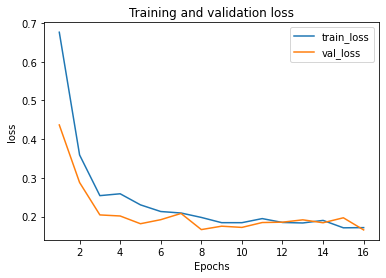

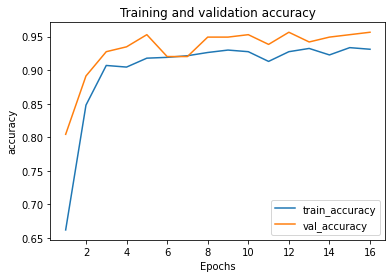

In [53]:
plot_metric(hist_rnn_y3,'loss')
plot_metric(hist_rnn_y3,'accuracy')

\pagebreak

# CM4

To summarize, the models which we have used for this dataset are:
<br> 1. a Deep NNet with 2 hidden layers (CM2)
<br> 2. a Deep NNet with 7 hidden layers 
<br> 3. a LSTM based NNet with Adam optimizer
<br> 4. a LSTM based NNet with SGD optimizer
<br> 5. a RNN based NNet
<br>
<br> For each of the models, two graphs have been plotted to understand more about their performance. The graphs include training and validation losses and accuracies with the no. of epochs. Also, the test accuracies in each case have been calculated and printed at the end of each model training details. The metrics have been copied into the table shown below. We get low performance and the test accuracies for models 1 and 5. Using LSTM (models 3 and 4), we get the best performance. Out of 3 and 4, we can see that model 4 performs even slightly better.

|                                   |               |                 |   |   |
|-----------------------------------|---------------|-----------------|---|---|
|                                   | Test Accuracy | Validation Loss |   |   |
|                CM2                |               |                 |   |   |
| Model 1: DNN with 2 hidden layers |               |                 |   |   |
| Confirmed                         | 0.971         | 0.1251          |   |   |
| Deaths                            | 0.906         | 0.2481          |   |   |
| Recovered                         | 0.641         | 0.1632          |   |   |
|                                   |               |                 |   |   |
|                CM3                |               |                 |   |   |
|  Model 2: DNN with  hidden layers |               |                 |   |   |
| Confirmed                         | 0.971         | 0.1167          |   |   |
| Deaths                            | 0.906         | 0.2489          |   |   |
| Recovered                         | 0.928         | 0.2047          |   |   |
|                                   |               |                 |   |   |
| Model 3: LSTM with Adam optimizer |               |                 |   |   |
| Confirmed                         | 0.971         | 0.0283          |   |   |
| Deaths                            | 0.909         | 0.077           |   |   |
| Recovered                         | 0.941         | 0.1072          |   |   |
|                                   |               |                 |   |   |
|  Model 4: LSTM with SGD optimizer |               |                 |   |   |
| Confirmed                         | 0.971         | 0.0288          |   |   |
| Deaths                            | 0.906         | 0.0932          |   |   |
| Recovered                         | 0.873         | 0.0989          |   |   |
|                                   |               |                 |   |   |
|      Model 5: RNN based NNet      |               |                 |   |   |
| Confirmed                         | 0.971         | 0.1467          |   |   |
| Deaths                            | 0.909         | 0.3445          |   |   |
| Recovered                         | 0.946         | 0.1657          |   |   |

\pagebreak

#CM5 Kaggle

Kaggle Group - Group 100

<br>Kaggle url- https://www.kaggle.com/c/ece657as21-asg3

<br>Group members- Amy Bhatia, Mengxuan Shi

In [ ]:
# load dkmacovid test data
df_test = pd.read_csv('dkmacovid_kaggletest_features.csv')
# remove comma from dataframe in 'Resident Population 2020 Census' and 'Population Density 2020 Census'
df_test = df_test.replace(',','', regex=True)
# convert string to numeric data
df_test['Resident Population 2020 Census'] = df_test['Resident Population 2020 Census'].astype(float) 
df_test['Population Density 2020 Census'] = df_test['Population Density 2020 Census'].astype(float) 
features=['Day','State ID','Lat','Long_','Active', 'Incident_Rate', 'Total_Test_Results', 'Case_Fatality_Ratio', 'Testing_Rate', 'Resident Population 2020 Census', 'Population Density 2020 Census', 'Density Rank 2020 Census', 'SexRatio']

df_test.head()
df_test_z= df_test.loc[:,features]

# df_z= df.loc[:,features]
df_test_z.iloc[:,:]=std_scaler.fit_transform(df_test_z.iloc[:,:])
X_kaggle= df_test_z.loc[:,features]
df_test_z.head()
X_kaggle = X_kaggle.values.reshape(X_kaggle.shape[0], 13,1)

In [ ]:
# REPLACE MODEL NAME AND Y1 2 3 FOR OTHER MODELS AND LABELS
model_trainer(model_LSTM, y1, X,100 )
y1_predict = model_LSTM.predict_classes(X_kaggle)

Epoch 1/100
 3/26 [==>...........................] - ETA: 1s - loss: 0.2474 - accuracy: 0.6667

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


26/26 [==============================] - 2s 66ms/step - loss: 0.2145 - accuracy: 0.7029 - val_loss: 0.1960 - val_accuracy: 0.7283
Epoch 2/100
26/26 [==============================] - 2s 64ms/step - loss: 0.1727 - accuracy: 0.7585 - val_loss: 0.1707 - val_accuracy: 0.7609
Epoch 3/100
26/26 [==============================] - 2s 64ms/step - loss: 0.1500 - accuracy: 0.7995 - val_loss: 0.1593 - val_accuracy: 0.7754
Epoch 4/100
26/26 [==============================] - 2s 60ms/step - loss: 0.1409 - accuracy: 0.8056 - val_loss: 0.1495 - val_accuracy: 0.7971
Epoch 5/100
26/26 [==============================] - 2s 61ms/step - loss: 0.1201 - accuracy: 0.8430 - val_loss: 0.1194 - val_accuracy: 0.8406
Epoch 6/100
26/26 [==============================] - 2s 59ms/step - loss: 0.0983 - accuracy: 0.8804 - val_loss: 0.1036 - val_accuracy: 0.8623
Epoch 7/100
26/26 [==============================] - 2s 60ms/step - loss: 0.0942 - accuracy: 0.8804 - val_loss: 0.0883 - val_accuracy: 0.8877
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
# REPLACE MODEL NAME AND Y1 2 3 FOR OTHER MODELS AND LABELS
model_trainer(model_LSTM, y2, X,100 )
y2_predict = model_LSTM.predict_classes(X_kaggle)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


26/26 [==============================] - 2s 65ms/step - loss: 0.0900 - accuracy: 0.9010 - val_loss: 0.0929 - val_accuracy: 0.8986
Epoch 2/100
26/26 [==============================] - 2s 63ms/step - loss: 0.0899 - accuracy: 0.8998 - val_loss: 0.0927 - val_accuracy: 0.8986
Epoch 3/100
26/26 [==============================] - 2s 62ms/step - loss: 0.0897 - accuracy: 0.9010 - val_loss: 0.0927 - val_accuracy: 0.8986
Epoch 4/100
26/26 [==============================] - 2s 59ms/step - loss: 0.0897 - accuracy: 0.8998 - val_loss: 0.0926 - val_accuracy: 0.8986
Epoch 5/100
26/26 [==============================] - 2s 60ms/step - loss: 0.0896 - accuracy: 0.9010 - val_loss: 0.0926 - val_accuracy: 0.8986
Epoch 6/100
26/26 [==============================] - 2s 61ms/step - loss: 0.0896 - accuracy: 0.9010 - val_loss: 0.0925 - val_accuracy: 0.8986
Epoch 7/100
26/26 [==============================] - 2s 63ms/step - loss: 0.0895 - accuracy: 0.9010 - val_loss: 0.0925 - val_accuracy: 0.8986
Epoch 8/100
26/26 

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
# REPLACE MODEL NAME AND Y1 2 3 FOR OTHER MODELS AND LABELS
model_trainer(model_LSTM, y3, X,100 )
y3_predict = model_LSTM.predict_classes(X_kaggle)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


26/26 [==============================] - 2s 65ms/step - loss: 0.3017 - accuracy: 0.6461 - val_loss: 0.2893 - val_accuracy: 0.6630
Epoch 2/100
26/26 [==============================] - 2s 65ms/step - loss: 0.2869 - accuracy: 0.6606 - val_loss: 0.2750 - val_accuracy: 0.6667
Epoch 3/100
26/26 [==============================] - 2s 62ms/step - loss: 0.2731 - accuracy: 0.6739 - val_loss: 0.2571 - val_accuracy: 0.6957
Epoch 4/100
26/26 [==============================] - 2s 59ms/step - loss: 0.2464 - accuracy: 0.6896 - val_loss: 0.2051 - val_accuracy: 0.7464
Epoch 5/100
26/26 [==============================] - 2s 61ms/step - loss: 0.1966 - accuracy: 0.7597 - val_loss: 0.1871 - val_accuracy: 0.7717
Epoch 6/100
26/26 [==============================] - 2s 61ms/step - loss: 0.1687 - accuracy: 0.7923 - val_loss: 0.1675 - val_accuracy: 0.7899
Epoch 7/100
26/26 [==============================] - 2s 64ms/step - loss: 0.1543 - accuracy: 0.8128 - val_loss: 0.1567 - val_accuracy: 0.8080
Epoch 8/100
26/26 

In [ ]:
import datetime
now = datetime.datetime.now()
time_string=now.strftime("%Y-%m-%d %H:%M")

Confirmed= pd.DataFrame(data= y1_predict, columns=['Confirmed']).astype(int)
Deaths= pd.DataFrame(data= y2_predict, columns=['Deaths']).astype(int)
Recovered= pd.DataFrame(data= y3_predict, columns=['Recovered']).astype(int)

ID = pd.DataFrame(df_test['Id'],columns=['Id'])
df_result=pd.concat([ID,Confirmed,Deaths,Recovered], axis=1)
df_result.to_csv('Kaggle_Decision_'+time_string+'.csv', index=False)

# References

[1] https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd

[2] https://www.kdnuggets.com/2019/11/designing-neural-networks.html

[3] https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/

[4] https://stats.stackexchange.com/questions/324896/training-loss-increases-with-time